You now know two kinds of regression and two kinds of classifier. So let's use that to compare models!

Comparing models is something data scientists do all the time. There's very rarely just one model that would be possible to run for a given situation, so learning to choose the best one is very important.

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

%matplotlib inline
#pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

c:\users\david\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Loading the data
data = pd.read_csv('C:\\Users\\david\Desktop\\thinkful datasets\\2017.csv')

data.head(5)

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [3]:
#Keeping only the columns we need for the model

needed_data = data.loc[:, ['Happiness.Score','Economy..GDP.per.Capita.', 'Family', 'Health..Life.Expectancy.','Freedom', 'Generosity', 'Trust..Government.Corruption.']]
needed_data.columns = ['Happiness_Score','Economy', 'Family', 'Life Expectancy', 'Freedom', 'Generosity', 'Government Trust']

needed_data.head(5)

,Happiness_Score,Economy,Family,Life Expectancy,Freedom,Generosity,Government Trust
0,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964
1,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770
2,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527
3,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007
4,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612


#### Build a Model that Predicts the Happiness of a Country

$$ Happiness = \alpha + Economy + Family + Life Expectancy + Freedom + Generosity + Government Trust $$

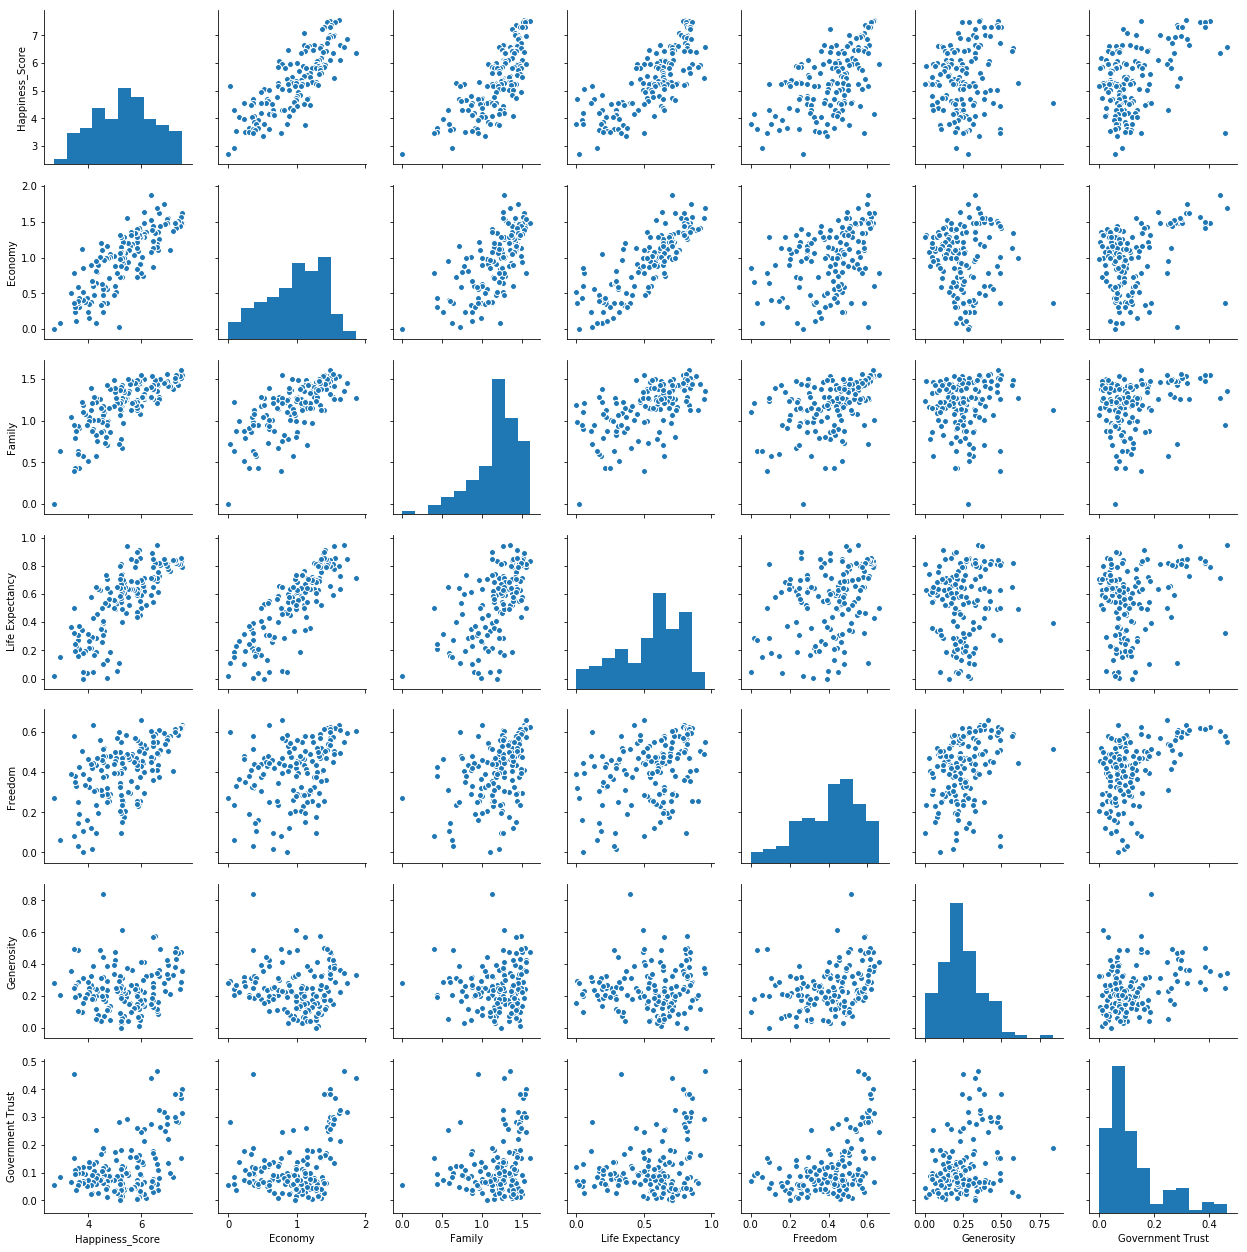

In [4]:
sns.pairplot(needed_data)

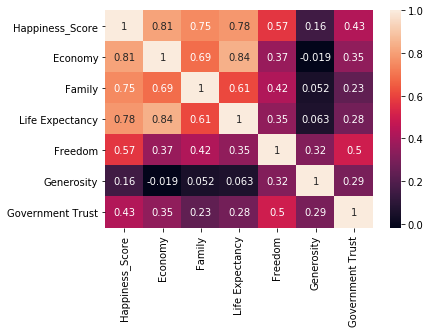

In [5]:
sns.heatmap(needed_data.corr(), annot=True)

### To make the variables more normally distributed I will performs some transformations 

We will start by taking the square root of the following: 
- Government Trust
- Generosity 
- Freedom
We do this because the data is skewed to the right and we are working to get them normally distributed

In [6]:
needed_data['sqrt_gov_trust'] = [math.sqrt(x) for x in  needed_data['Government Trust']]
needed_data['sqrt_generosity'] = [math.sqrt(x) for x in  needed_data['Generosity']]
needed_data['sqrt_freedom'] = [math.sqrt(x) for x in  needed_data['Freedom']]

Next, we will square the following: 
- Family
- Life Expectancy 

We do this because the data is skewed to the left and we are working to get them normally distributed

In [7]:
needed_data['sqr_family'] = [np.square(x) for x in  needed_data['Family']]
needed_data['sqr_lifeexp'] = [np.square(x) for x in  needed_data['Life Expectancy']]


In [48]:
needed_data['log_gov_trust'] = [np.log(x+.00001) for x in  needed_data['Government Trust']]
needed_data['log_economy'] = [np.log(x+.00001) for x in  needed_data['Economy']]
needed_data['log_freedom'] = [np.log(x+.00001) for x in  needed_data['Freedom']]
needed_data['log_lifeexp'] = [np.log(x+.00001) for x in  needed_data['Life Expectancy']]
needed_data['log_family'] = [np.log(x+.00001) for x in  needed_data['Family']]

In [42]:
#Now let's take a look at our new dataframe and see if the columns changed correctly
needed_data['Life Expectancy'].describe()

count    155.000000
mean       0.551341
std        0.237073
min        0.000000
25%        0.369866
50%        0.606042
75%        0.723008
max        0.949492
Name: Life Expectancy, dtype: float64

In [46]:
data.loc[needed_data['log_gov_trust'].idxmin()]

Country                          Bosnia and Herzegovina
Happiness.Rank                                       90
Happiness.Score                                   5.182
Whisker.high                                    5.27634
Whisker.low                                     5.08766
Economy..GDP.per.Capita.                       0.982409
Family                                          1.06934
Health..Life.Expectancy.                       0.705186
Freedom                                        0.204403
Generosity                                     0.328867
Trust..Government.Corruption.                         0
Dystopia.Residual                               1.89217
Name: 89, dtype: object

In [44]:
data.loc[needed_data['Freedom'].idxmin()]

Country                             Angola
Happiness.Rank                         140
Happiness.Score                      3.795
Whisker.high                       3.95164
Whisker.low                        3.63836
Economy..GDP.per.Capita.          0.858428
Family                             1.10441
Health..Life.Expectancy.         0.0498687
Freedom                                  0
Generosity                       0.0979265
Trust..Government.Corruption.    0.0697203
Dystopia.Residual                  1.61448
Name: 139, dtype: object

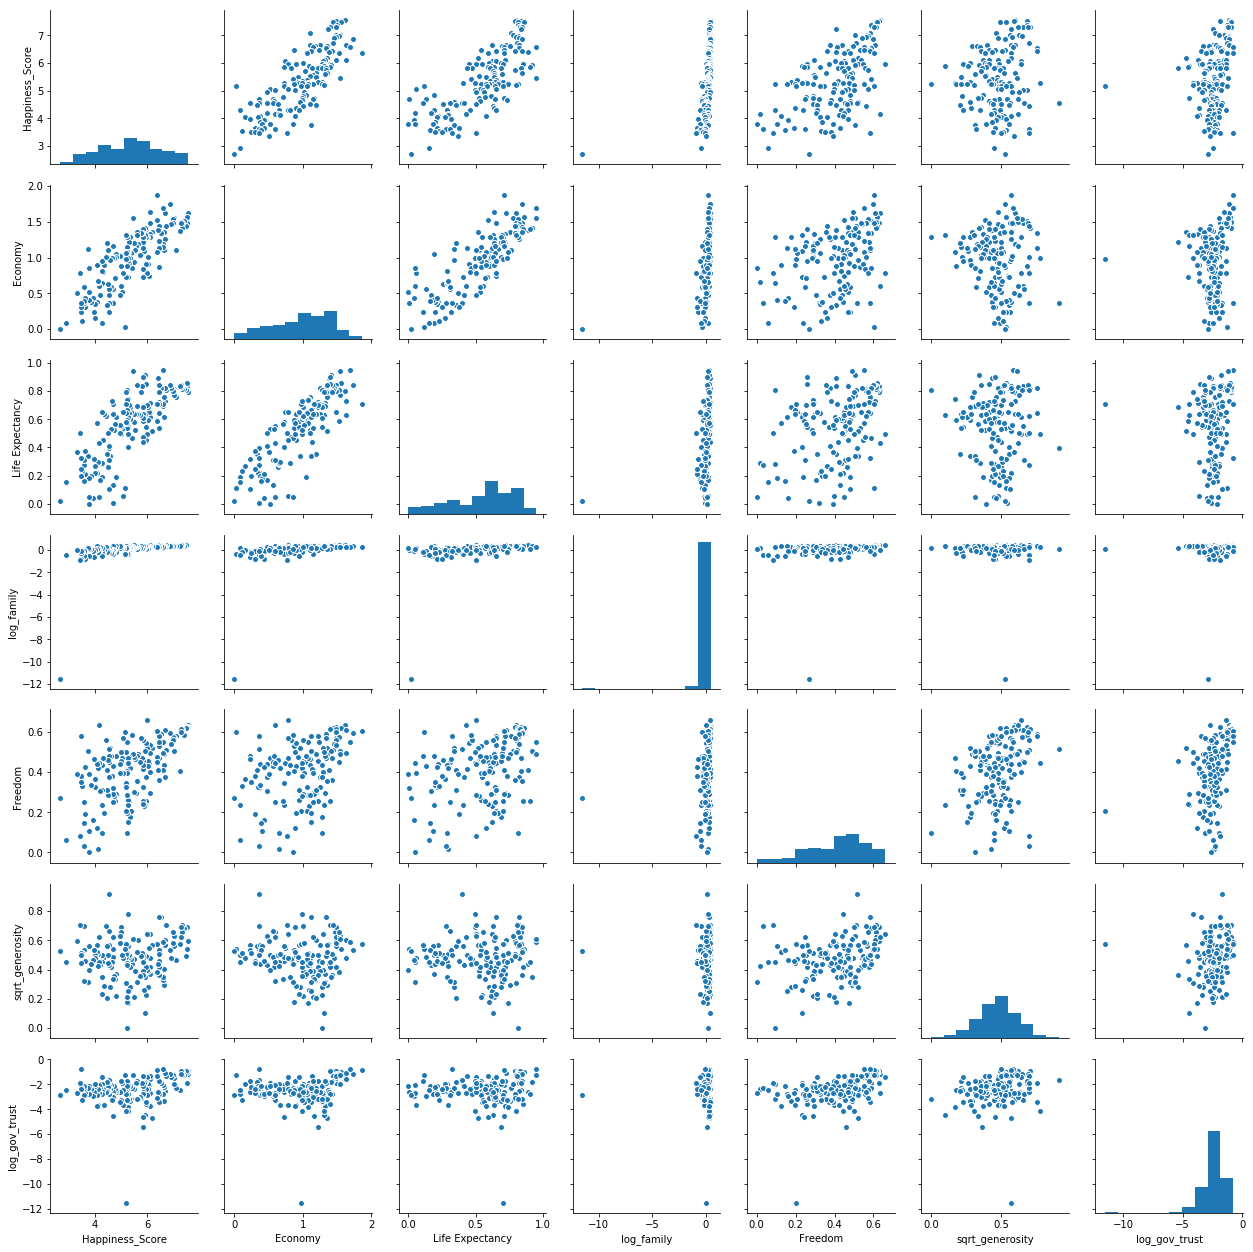

In [49]:
#Let's next take a look at the pairplot and see if we made some significant changes

#sns.pairplot(needed_data[['Happiness_Score','Economy', 'sqr_lifeexp','sqr_family','sqrt_freedom','sqrt_generosity','sqrt_gov_trust']])

#sns.pairplot(needed_data[['Happiness_Score','Economy', 'Life Expectancy','sqr_family','Freedom','sqrt_generosity','Government Trust']])

#sns.pairplot(needed_data[['Happiness_Score','log_economy', 'log_lifeexp','sqr_family','log_freedom','sqrt_generosity','log_gov_trust']])

sns.pairplot(needed_data[['Happiness_Score','Economy', 'Life Expectancy','log_family','Freedom','sqrt_generosity','log_gov_trust']])

### Creating a Linear Regression Model

Since we are a bit more comfortable with the new transformations let's create our OLS model

In [10]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = needed_data['Happiness_Score'].values.reshape(-1, 1)
X = needed_data[['Economy', 'sqr_lifeexp','sqr_family','sqrt_freedom','sqrt_generosity','sqrt_gov_trust']]
#X = needed_data[['Population', 'Property\ncrime', 'Robbery','Burglary','Larceny-\ntheft', 'Motor\nvehicle\ntheft']]
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

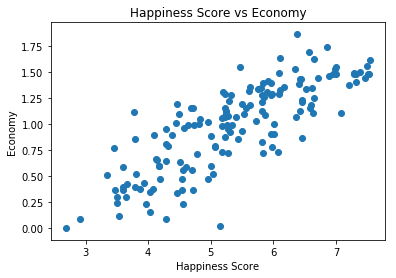

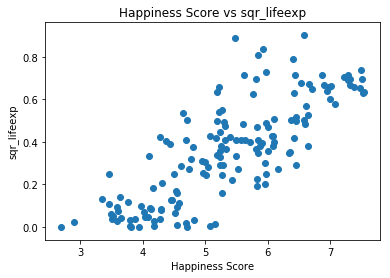

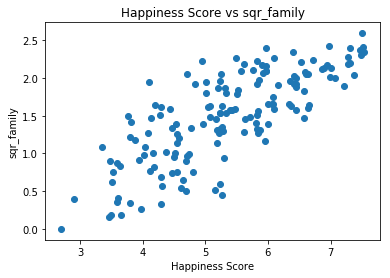

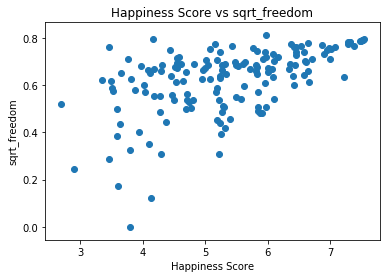

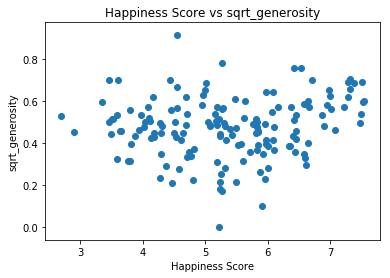

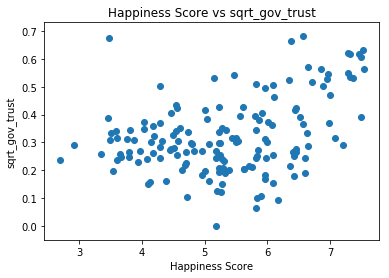


Coefficients: 
 [[0.75807527 1.29770165 0.5960271  1.43840724 0.39913714 0.58044014]]

Intercept: 
 [1.97391176]

R-squared:
0.8196366273210879


In [11]:
for each in X:
    plt.scatter(needed_data['Happiness_Score'], needed_data[each])
    plt.title('Happiness Score vs ' + each)
    plt.xlabel('Happiness Score')
    plt.ylabel(each)
    plt.show()
    
# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

In [12]:
score = cross_val_score(regr, X, Y, cv=5)
print(" Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

 Accuracy: -4.98 (+/- 6.18)


In [13]:
linear_formula = 'Happiness_Score ~ sqr_lifeexp+sqr_family+sqrt_freedom+sqrt_generosity+sqrt_gov_trust'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=needed_data).fit()
needed_data.head(5)

,Happiness_Score,Economy,Family,Life Expectancy,Freedom,Generosity,Government Trust,sqrt_gov_trust,sqrt_generosity,sqrt_freedom,sqr_family,sqr_lifeexp
0,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,0.562107,0.601675,0.797134,2.351695,0.634678
1,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,0.633064,0.596054,0.791206,2.405978,0.628160
2,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,0.391825,0.689594,0.791936,2.593949,0.694809
3,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,0.605811,0.539026,0.787446,2.301021,0.736389
4,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,0.618556,0.495462,0.786099,2.372360,0.654736


In [14]:
lm.pvalues

Intercept          6.565681e-20
sqr_lifeexp        4.420907e-17
sqr_family         1.676650e-13
sqrt_freedom       5.291946e-05
sqrt_generosity    7.335224e-01
sqrt_gov_trust     2.766984e-02
dtype: float64

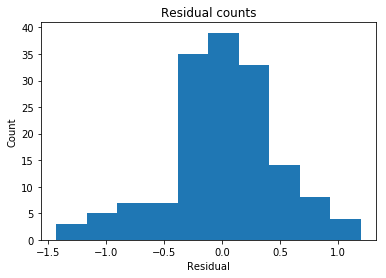

In [15]:
# Assumption two: multivariate normality

predicted = regr.predict(X).ravel()
actual = needed_data["Happiness_Score"]
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

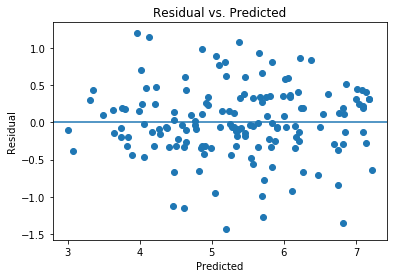

In [16]:

# Assumption three: homoscedasticity# Assump 
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### K- Nearest Neighbor Regression

In [17]:
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
Y = needed_data['Happiness_Score'].values.reshape(-1, 1)
X = needed_data[['Economy', 'sqr_lifeexp','sqr_family','sqrt_freedom','sqrt_generosity','sqrt_gov_trust']]

# Build our model.

knn.fit(X, Y)

#y_pred = knn.predict(X)

print('\nR-squared:')
print('%.3f' % (knn.score(X, Y)) )

knn_score = cross_val_score(knn, X, Y, cv=5)
print("\nAccuracy: %0.2f (+/- %0.2f)" % (knn_score.mean(), knn_score.std() * 2))


R-squared:
0.817

Accuracy: -8.69 (+/- 7.23)


### Let's now weight the KNN scores

In [18]:
knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
Y = needed_data['Happiness_Score'].values.reshape(-1, 1)
X = needed_data[['Economy', 'sqr_lifeexp','sqr_family','sqrt_freedom','sqrt_generosity','sqrt_gov_trust']]

# Build our model.

knn_w.fit(X, Y)

#y_pred = knn_w.predict(X)

print('\nR-squared:')
print('%.3f' % (knn_w.score(X, Y)) )

knnw_score = cross_val_score(knn_w, X, Y, cv=5)
print("\nAccuracy: %0.2f (+/- %0.2f)" % (knnw_score.mean(), knnw_score.std() * 2))



R-squared:
1.000

Accuracy: -9.47 (+/- 10.67)
